# Welcome and have fun learning Logistic Regession with plug and play Neural Network
### There are alot of category features in the dataset. Lets forget about feature engineering and just brute force NN for now.
<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

Notes:
Run time -
4 hours and 31 minutes 4000000 samples
3318.3s 395712 samples

## Imports and Configuration ##

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


In [2]:
# -----------------------------------------------------------------
# Some parameters to config 

EPOCHS = 362
BATCH_SIZE = 2048 # large enough to fit RAM
ACTIVATION = 'swish'
LEARNING_RATE = 0.000265713 # Optimal lr is about half the maximum lr
FOLDS = 5

# The dataset is too huge for free contrainer. Sampling it for more fun!
VALIDATION_SPLIT = 0.005 # Only used to min dataset for quick test
SAMPLE = 1468136 # [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
MAX_TRIAL = 3 # speed trial any% Not used here

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id" # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [3]:
from pathlib import Path
def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
#     df = clean(df)
#     df = encode(df)
#     df = impute(df)
    df_train = impute(df_train)
    df_test = impute(df_test)
    # Reform splits
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]
    return df_train, df_test

### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [4]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [5]:
train_data, test_data = load_data()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
column_y = train_data.columns.difference(test_data.columns)[0]
x = train_data.drop(columns=column_y)
y = train_data[[column_y]]

x_test = test_data.iloc[:,:]

## For quick test
y

(array([1, 2, 3, 4, 5, 6, 7]),
 
 array([1468136, 2262087,  195712,     377,       1,   11426,   62261]))
 
TomekLinks
(array([1, 2, 3, 4, 5, 6, 7]),

 array([1390684, 2169226,  155218,     218,       1,    7627,   38757]))

In [7]:
# Check NA
missing_val = x.isnull().sum()
print(missing_val[missing_val > 0])

from sklearn.model_selection import train_test_split 
# For small testing batch
# x, x_val, y, y_val = train_test_split(x, y, train_size = VALIDATION_SPLIT, random_state = RANDOM_STATE)
# x = x.sample(n=SAMPLE, random_state=RANDOM_STATE)
# y = y.sample(n=SAMPLE, random_state=RANDOM_STATE)
# x_test = x_test.sample(n=SAMPLE, random_state=RANDOM_STATE)

# undersample = TomekLinks(sampling_strategy='auto') #, random_state=RANDOM_STATE not minority RandomUnderSampler
# X_under, y_under = undersample.fit_resample(x, y)

Series([], dtype: int64)


# Undersampling

In [8]:
# small_sampling = train_data.groupby(column_y).apply(lambda s: s.sample(min(len(s), 5)))

In [9]:
sampling_key, sampling_count = np.unique(y, return_counts=True)
sampling_count[sampling_count > SAMPLE] = SAMPLE
zip_iterator = zip(sampling_key, sampling_count)
sampling_params = dict(zip_iterator)

In [10]:
#, random_state=RANDOM_STATE not minority RandomUnderSampler
undersample = RandomUnderSampler(
    sampling_strategy=sampling_params, random_state=RANDOM_STATE)

x, y = undersample.fit_resample(x, y)

In [11]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]),
 array([1468136, 1468136,  195712,     377,       1,   11426,   62261]))

y to categorical

In [12]:
# Prepare for multiclass classification
y_cat = tf.keras.utils.to_categorical(y - 1)

In [13]:
y.shape

(3206049, 1)

In [14]:
y_cat.shape

(3206049, 7)

In [15]:
# x_num = x.select_dtypes(include=[np.number])
# x_cat = x.select_dtypes(include=['object'])

In [16]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# for i in range(1,5):
#     x[f'Wilderness_Area{i}'] = le.fit_transform(x[f'Wilderness_Area{i}'])
#     x_test[f'Wilderness_Area{i}'] = le.fit_transform(x_test[f'Wilderness_Area{i}'])
# for i in range(1,41):
#     x[f'Soil_Type{i}'] = le.fit_transform(x[f'Soil_Type{i}'])
#     x_test[f'Soil_Type{i}'] = le.fit_transform(x_test[f'Soil_Type{i}'])



# Scaler transformer
By using RobustScaler(), we can remove the outliers
![](https://github.com/furyhawk/kaggle_practice/blob/main/images/Scalers.png?raw=true)

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_all_cols = make_pipeline(
    RobustScaler(),
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_all_cols, x.columns[:]),
)

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

In [18]:
def load_model():
    
    early_stopping = EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_acc',
        restore_best_weights=True,
        verbose=VERBOSE,
        mode='max',
        baseline=None,
    )
    plateau = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5, 
            verbose=VERBOSE,
            mode='min')

# -----------------------------------------------------------------
# Model 

    model = keras.Sequential([
    layers.BatchNormalization(input_shape = [x.shape[1]], name='input'),
    layers.Dense(108, activation=ACTIVATION),
#     layers.Dropout(rate = 0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation=ACTIVATION),
#     layers.Dropout(rate = 0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation=ACTIVATION), 
#     layers.Dropout(rate = 0.3),
    layers.Dense(y_cat.shape[1], activation = 'softmax'),
    ])

# -----------------------------------------------------------------
# sparse_categorical_crossentropy
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['acc'],
    )
    
    return model, early_stopping, plateau

# Kfold

In [19]:
def plot_acc(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [20]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

preds_valid_f = {}
preds_test = []
total_acc = []
f_scores = []

kf = StratifiedKFold(n_splits=FOLDS,random_state=RANDOM_STATE,shuffle=True)

In [21]:
test  = test_data.copy()
test = preprocessor.fit_transform(test)

for fold,(train_index, valid_index) in enumerate(kf.split(x, y=y.Cover_Type)):

    X_train, X_valid = x.iloc[train_index], x.iloc[valid_index]
    y_train, y_valid = y_cat[train_index], y_cat[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    
    index_valid  = X_valid.index.tolist()
    
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    
    #  ----------------------------------------------------------    
    # Model
    
    model, early_stopping, plateau  = load_model()

    history = model.fit(  X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size = BATCH_SIZE, 
                epochs = EPOCHS,
                callbacks = [early_stopping, plateau],
                shuffle = True,
                verbose = 0
              )
    
    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid, batch_size=BATCH_SIZE)
    
    #  ----------------------------------------------------------
    #  test dataset predictions for submission np.argmax(, axis=1) + 1
    preds_test.append(np.argmax(model.predict(test, batch_size=BATCH_SIZE), axis=1) + 1)

    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    if fold == 0:
        f_scores = scores 
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)
        
    #  ----------------------------------------------------------
    #  concatenating valid preds
    # Getting score for a fold model
    fold_acc = accuracy_score(y.iloc[valid_index].Cover_Type, np.argmax(preds_valid, axis=1) + 1)
    print(f"Fold {fold} accuracy_score: {fold_acc}")

    # Total auc
    total_acc.append(fold_acc)
    
    del model
    gc.collect()

print(f"mean accuracy_score: {np.mean(total_acc)}, std: {np.std(total_acc)}")

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TE

Fold 0 accuracy_score: 0.9524773475148547
Fold 1 accuracy_score: 0.9568316152274606
Fold 2 accuracy_score: 0.9578889911261521
Fold 3 accuracy_score: 0.9577501910450554
Fold 4 accuracy_score: 0.9540960903543151
mean accuracy_score: 0.9558088470535676, std: 0.0021528722805034942


# Evaluation

Validation Loss: 0.1052
Validation Loss: 0.0941
Validation Loss: 0.0909
Validation Loss: 0.0917
Validation Loss: 0.1008


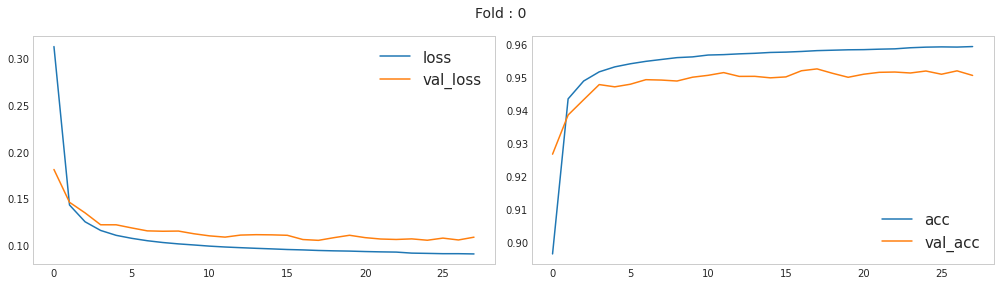

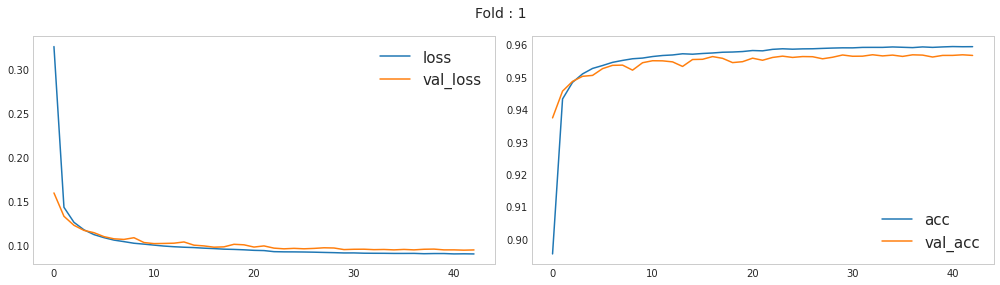

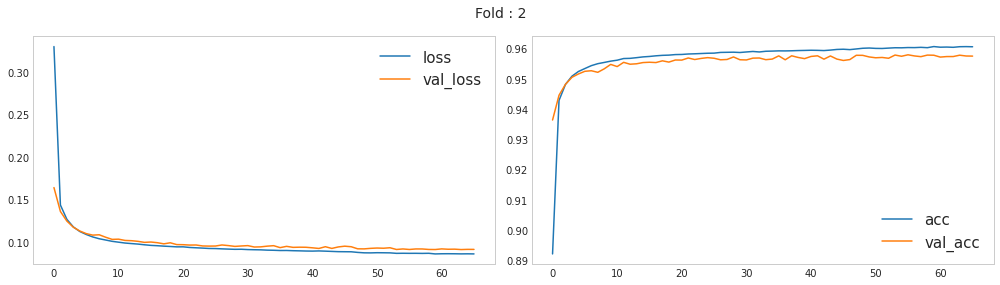

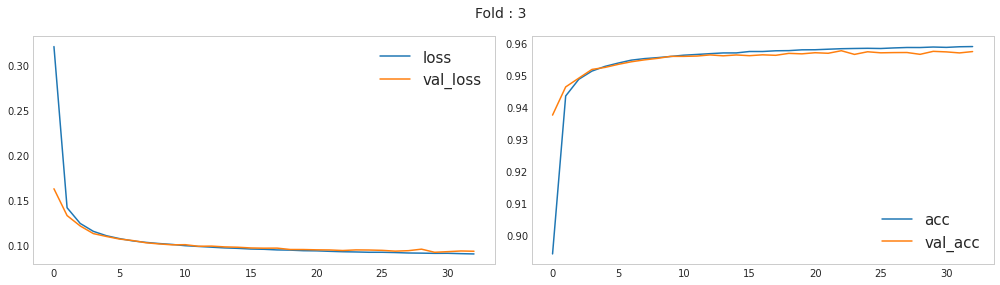

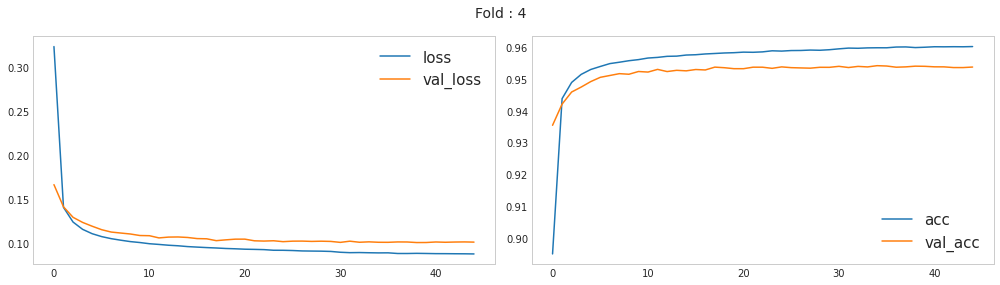

In [22]:
for fold in range(f_scores['folds'].nunique()):
    history_f = f_scores[f_scores['folds'] == fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('Fold : '+str(fold), fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=15)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, ['acc', 'val_acc']],label= ['acc', 'val_acc'])
    plt.legend(fontsize=15)
    plt.grid()
    
    print("Validation Loss: {:0.4f}".format(history_f['val_loss'].min()));

# Submission

In [23]:
sub = pd.read_csv(INPUT + '/sample_submission.csv')
sub[column_y] = (stats.mode(preds_test)[0][0]) # preds_test[FOLDS-1] # argmax reverse of to_categorical sub[column_y] = (np.argmax(sum(preds_test), axis=1) + 1)
sub.to_csv('submission.csv', index=False)
sub

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
...,...,...
999995,4999995,2
999996,4999996,1
999997,4999997,2
999998,4999998,1


In [24]:
np.unique(sub[column_y], return_counts=True)

(array([1, 2, 3, 4, 6, 7]),
 array([403668, 495537,  54297,      1,   2392,  44105]))

In [25]:
# np.array(preds_test).shape

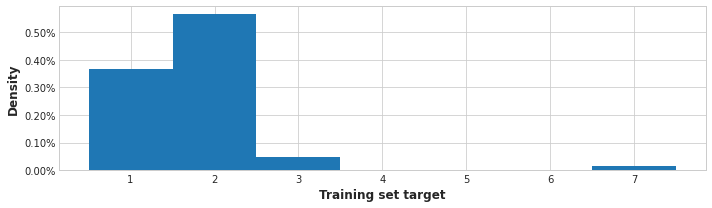

In [26]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter

# Plot the distribution of the training set target
plt.figure(figsize=(10,3))
plt.hist(train_data[column_y], bins=np.linspace(0.5, 7.5, 8), density=True)
plt.xlabel('Training set target')
plt.ylabel('Density')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.show()

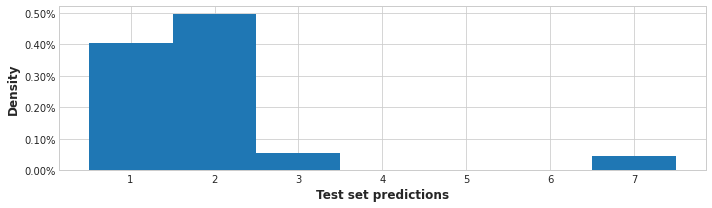

In [27]:
# Plot the distribution of the test predictions
plt.figure(figsize=(10,3))
plt.hist(sub[column_y], bins=np.linspace(0.5, 7.5, 8), density=True)
plt.xlabel('Test set predictions')
plt.ylabel('Density')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


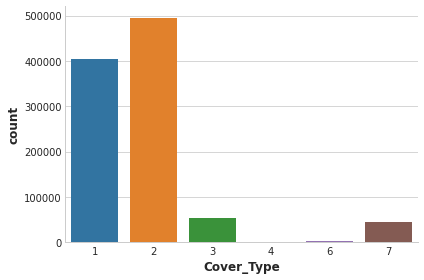

In [28]:
# Plot the distribution of the test predictions
sns.countplot(sub[column_y])
sns.despine()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


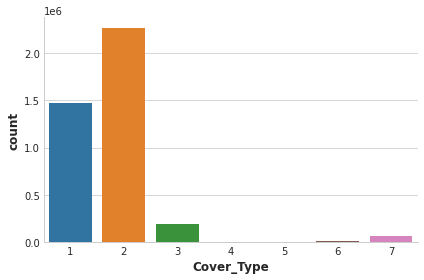

In [29]:
# Plot the distribution of the training set
sns.countplot(train_data[column_y])
sns.despine()

keys_list, values_list = np.unique(my_list, return_counts=True)keys_list, values_list = np.unique(my_list, return_counts=True)To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!